<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/Analyse_ACP_creature_classlevelstats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas sqlalchemy
!pip install mysqlclient

In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt


# Remplacer les éléments suivants par vos propres informations de connexion
database_type = 'mysql' # ou 'postgresql', 'mssql', 'oracle', etc.
username = 'alpha_core'
password = 'alpha_core'
host = '151.80.238.100'
port = '3306'
database_name = 'alpha_world'

# Créer l'URL de connexion pour SQLAlchemy
engine_url = f'{database_type}://{username}:{password}@{host}:{port}/{database_name}'

# Créer l'objet 'engine'
engine = create_engine(engine_url)


# Connecter la base de données avec l'objet engine
with engine.connect() as connection:
    # Exécuter la requête SQL
    result = connection.execute(text('SELECT * FROM creature_classlevelstats'))

    # Convertir le résultat en un DataFrame pandas
    dataframe = pd.DataFrame(result.fetchall())
    dataframe.columns = result.keys()
    dataframe = dataframe.drop(columns=['id'])


 # Sélectionner uniquement les données numériques
df_num = dataframe.select_dtypes(include=['int64', 'float64'])

# Changer NaN Par 0
dataframe.fillna(0, inplace=True)

# Calculer la moyenne et l'écart-type pour chaque colonne
mean = df_num.mean()
std = df_num.std()

# Centrer et réduire les données pour chaque élément
df_normalized = (df_num - mean) / std

print(df_normalized)


        class     level  melee_damage  ranged_damage  attack_power  \
0   -0.862098 -1.724144     -1.329962      -1.337902     -1.122977   
1   -0.862098 -1.710568     -1.327036      -1.334502     -1.119857   
2   -0.862098 -1.696992     -1.323283      -1.330720     -1.116737   
3   -0.862098 -1.683416     -1.318335      -1.324945     -1.113616   
4   -0.862098 -1.669840     -1.312323      -1.317882     -1.110496   
..        ...       ...           ...            ...           ...   
760  1.400910  1.669840      1.431168       0.872090      0.772522   
761  1.400910  1.683416      1.449184       0.884241      0.788122   
762  1.400910  1.696992      1.467256       0.896416      0.803723   
763  1.400910  1.710568      1.485384       0.908620      0.819324   
764  1.400910  1.724144      1.503568       0.920853      0.834925   

     ranged_attack_power    health  base_health      mana  base_mana  \
0              -1.032204 -1.132362    -1.108831 -0.703920  -0.747396   
1              

In [3]:
from sklearn.decomposition import PCA


# Effectuer l'ACP
pca = PCA(n_components=2)
X_r = pca.fit_transform(df_normalized)

# Composantes de pca.components_
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [4]:
# Print the explained variance ratio for each component
total = 0
for i, variance_ratio in enumerate(pca.explained_variance_ratio_):
    print(f'PC{i+1}: {variance_ratio:.2%}')
    total += variance_ratio

print(f"TOT: {total:.2%}")

PC1: 68.36%
PC2: 23.94%
TOT: 92.30%


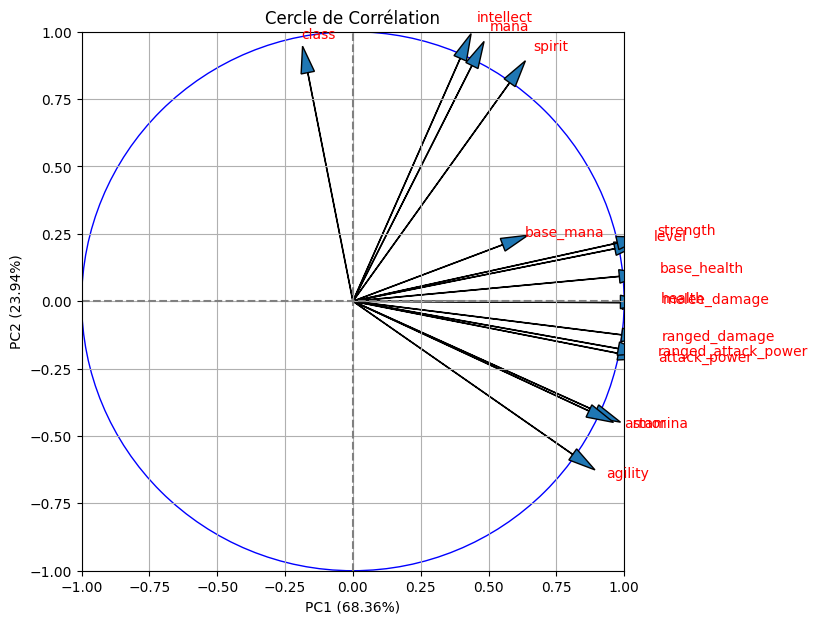

In [5]:
# Création du cercle de corrélation
fig, ax = plt.subplots(figsize=(7, 7))
circle = plt.Circle((0, 0), 1, color='blue', fill=False)

ax.add_artist(circle)

# Ajout des vecteurs des loadings
for i in range(len(loadings)):
    ax.arrow(0, 0, loadings[i, 0], loadings[i, 1], head_width=0.05, head_length=0.1)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, df_normalized.columns[i], color='red')

# Limites et étiquettes du graphique
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax.set_title('Cercle de Corrélation')

# Affichage du cercle de corrélation
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid()
plt.show()

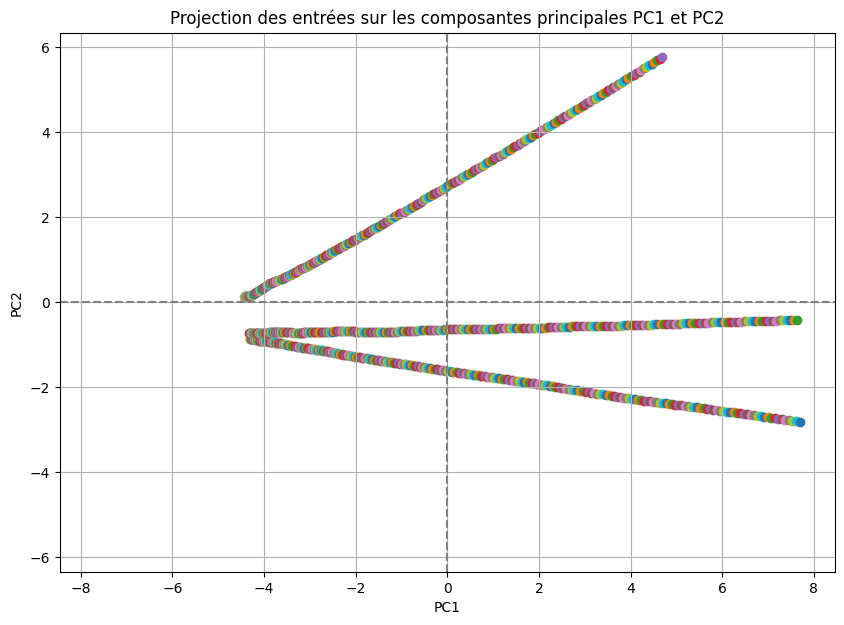

In [6]:
# Création du graphique du nuage de points
fig, ax = plt.subplots(figsize=(10, 7))

# Projection des individus sur les PC1 et PC2
for i in range(len(X_r)):
    plt.scatter(X_r[i, 0], X_r[i, 1])

# Définir les limites pour une meilleure lisibilité
x_lim = max(abs(X_r[:, 0])) * 1.1
y_lim = max(abs(X_r[:, 1])) * 1.1
ax.set_xlim(-x_lim, x_lim)
ax.set_ylim(-y_lim, y_lim)

# Titres et étiquettes des axes
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Projection des entrées sur les composantes principales PC1 et PC2')

# Lignes de référence
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.grid()

# Affichage du graphique
plt.show()